In [68]:
def importdata():
    df = pd.read_csv('../data/df_points_18-19-20-21_v1_weather_final.csv')
    df = df[['bike_id','lat','lng','timestood','time_start','time_end','hex_id']]
    df['time_start'] = pd.to_datetime(df['time_start'])
    
    return df

In [69]:
def create_onedf_hexid(df,hex_id):
    onedfhexid = pd.DataFrame(columns= ['bike_id','lat','lng','timestood','time_start','time_end','flag','hex_id'])
    for ind in tqdm(df.index):
        if df['hex_id'][ind] == hex_id:
            onedfhexid.loc[df.index[ind]] = df.iloc[ind]
            #onedfhexid.append(df[ind], ignore_index = True)
    return onedfhexid.reset_index(drop=True)

In [70]:
def create_tsdata(_year,_days):
    rng = pd.date_range(f'{_year}-01-01', periods=_days, freq='D')
    tsdata = pd.DataFrame({ 'date': rng, 'idle_time' : np.nan, 'list': np.nan, 'bike_count': np.nan}) 
    return tsdata.set_index('date')

In [71]:
def add_rows_to_days(tsdata,onedfhexid):
    # iteriere über alle Tage
    for date in tqdm(tsdata.index):
        list = []
        # Adde alle Rows in die List wenn Tag = Tag
        for ind in onedfhexid.index:
            if date.date() == onedfhexid['time_start'][ind].date():
                list.append(onedfhexid['timestood'][ind])
        #print(len(list))        
        # Setze Mittelwert für Tage
        if len(list) == 0:
            tsdata['bike_count'][date] = 1
            continue
        else:
            tsdata['bike_count'][date] = len(list)
            tsdata['idle_time'][date] = statistics.mean(list)
    return tsdata

In [72]:
def get_rows_one_day(day,onedfhexid):
    list=[]
    for ind in onedfhexid.index:
        if day == onedfhexid['time_start'][ind].date():
            list.append(onedfhexid['timestood'][ind])
    print(list)
    print(statistics.mean(list))

In [73]:
def roling_weighted_mean(tsdata,_year,_days):
    x = []
    rng2 = pd.date_range(f'{_year}-01-01', periods=_days, freq='D')
    data_mean2 = pd.DataFrame({ 'date': rng2, 'idle_time' : np.nan})
    data_mean2 = data_mean2.set_index('date')
    
    for window in tsdata.rolling(window = 7 , center = True):
        #print(window)
        x.append(np.average(window['idle_time'], weights = window['bike_count']))
    
    data_mean2['idle_time'] = x
    return data_mean2

In [74]:
def plot(x):
    fig, ax1 = plt.subplots(figsize = (20,10))
    
    ax1.plot(x['idle_time'], linewidth=2,color='red', label='Idle Time Mean')
    ax1.set_xlabel('day')
    ax1.set_ylabel('timestood (min)')
    ax1.tick_params(axis ='y', labelcolor = 'red') 
    
    ax2 = ax1.twinx()
    ax2.plot(x['bike_count'], linewidth=2, label='bike_count')
    ax2.set_ylabel('bike_count')
    ax2.tick_params(axis ='y', labelcolor = 'blue')
    
    plt.show()

In [75]:
def plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id,total_bike_count):
    fig, ax = plt.subplots(figsize = (20,10))
    
    # plotting daily data
    ax.plot(tsdata['idle_time'], marker='.', markersize=2, color='0.6',linestyle='None', label='Daily')
    # plotting 7-day rolling data
    ax.plot(data_7d_rol['idle_time'],color = 'blue', linewidth=2, label='7-d Rolling Mean')
    ax.plot(data_7d_mean2['idle_time'],color = 'green', linewidth=2, label='7-d Rolling Mean')
    # plotting 2-Month rolling data -trend-
    ax.plot(data_2m_rol['idle_time'], color='0.2', linewidth=3, label='Trend (2M)')
    ax.legend()
    ax.set_xlabel('day')
    ax.set_ylabel('timestood (min)')
    ax.set_title(f'Trends in idel time of bikes in hex: {hex_id} with a total of {total_bike_count} rentals')
    
    ax2 = ax.twinx()
    ax2.plot(data_7d_rol['bike_count'],linewidth=1, color='0.5',label='Bike Count 7-d RM')
    ax2.set_xlabel('day')
    ax2.set_ylabel('bikes in hex per day')
    ax2.legend()
    
    plt.show()

In [76]:
def fix_missing_values(tsdata):
    data_freq = tsdata.asfreq('D')
    data_freq = data_freq.ffill()
    return data_freq

# Main

In [77]:
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
from datetime import timedelta, datetime, date
pd.set_option('display.max_rows', None)
import weightedstats

import numpy as np
import statistics
import matplotlib.pyplot as plt

### Define the HEX_id

#hex_id = '8a1f1a8d9d97fff'
#hex_id = '8a1f1a8cb4cffff'
#hex_id = '8a1f1a8cb4dffff'
#hex_id = '8a1f1a8cb71ffff'
hex_id = '881f1a8cb7fffff'

days=1364
year=2018
data_columns = ['idle_time','bike_count']

df = importdata()
onedfhexid = create_onedf_hexid(df,hex_id)
tsdata = create_tsdata(year,days)
tsdata = add_rows_to_days(tsdata,onedfhexid)
#fix missing values with ffill

100%|███████████████████████████████████████| 1364/1364 [18:20<00:00,  1.24it/s]


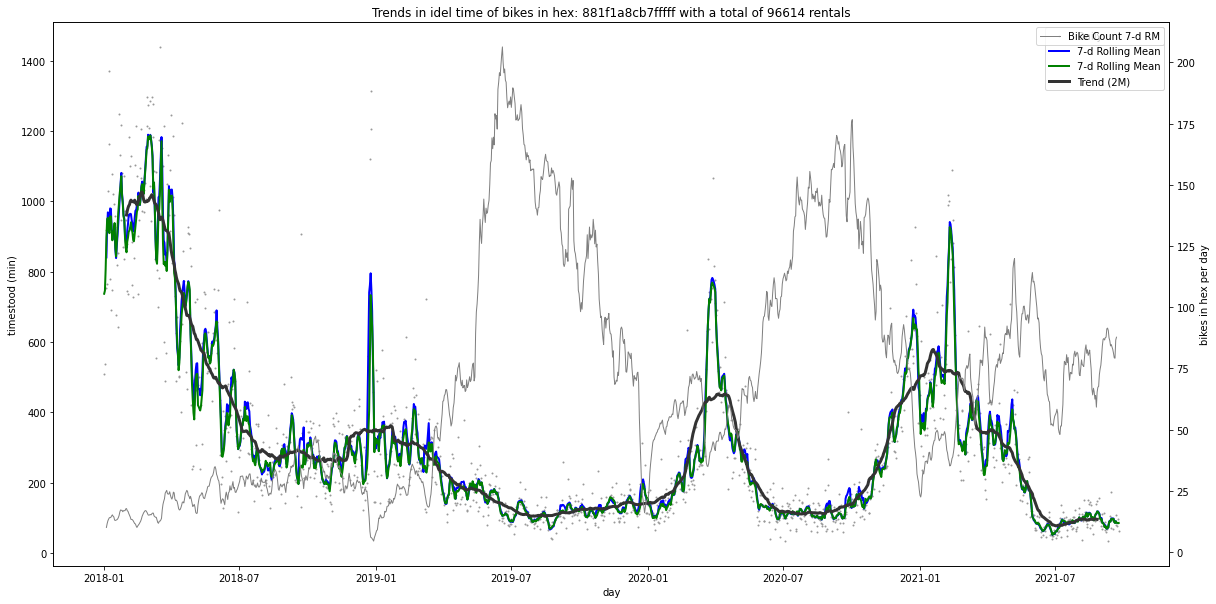

In [78]:
tsdata = fix_missing_values(tsdata)
total_bike_count = int(tsdata['bike_count'].sum())

data_7d_rol = tsdata[data_columns].rolling(window = 7, center = True).mean()
data_2m_rol = tsdata[data_columns].rolling(window = 60, center = True).mean()
data_7d_mean2 = roling_weighted_mean(tsdata,year,days)


plot_details(tsdata,data_7d_rol,data_2m_rol,data_7d_mean2,hex_id,total_bike_count)

# Begin Predicition

In [79]:
dfw = pd.read_csv('/Users/jonweske/devment/BA_nextbike/data/weather_data.csv')
dfw['datetime'] = pd.to_datetime(dfw['dt'], unit='s')
dfw = dfw.set_index(['datetime'])
dfw.head()

tsdata['temp'] = np.nan
tsdata['rain'] = np.nan
tsdata['snow'] = np.nan


for ind in tqdm(tsdata.index):
    wint = ind.replace(hour=12,minute=0,second=0)
    tsdata['temp'][ind] = dfw['temp'][wint].copy()
    tsdata['rain'][ind] = dfw['rain_1h'][wint].copy()
    tsdata['snow'][ind] = dfw['snow_1h'][wint].copy()

100%|█████████████████████████████████████| 1364/1364 [00:00<00:00, 1398.94it/s]


In [80]:
#del tsdata['list']
tsdata.head()

,idle_time,list,bike_count,temp,rain,snow
date,,,,,,
2018-01-01,509.500000,NaN,2.0,8.67,NaN,NaN
2018-01-02,536.714286,NaN,7.0,5.11,NaN,NaN
2018-01-03,919.000000,NaN,9.0,6.11,NaN,NaN
2018-01-04,753.615385,NaN,13.0,8.11,NaN,NaN
2018-01-05,764.000000,NaN,15.0,10.11,NaN,NaN


In [81]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [112]:
# creating new dataframe from idle_time column + bike_count
data_consumption = tsdata[['idle_time']]
data_consumption.loc[:,'bike_count'] = tsdata[['bike_count']]

# inserting new column with yesterday last_week and last_year plus Diffs
data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:,'idle_time'].shift()
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,'Yesterday'].diff()



# add weather data temp + rain + snow
data_consumption.loc[:,'temp'] = tsdata[['temp']]
data_consumption.loc[:,'rain'] = tsdata[['rain']]
data_consumption.loc[:,'snow'] = tsdata[['snow']]

# Nan s to 0 
data_consumption = data_consumption.fillna(0)

In [113]:
data_consumption.tail()

,idle_time,bike_count,Yesterday,Yesterday_Diff,temp,rain,snow
date,,,,,,,
2021-09-21,79.357143,84.0,90.793103,-0.312957,16.03,0.0,0.0
2021-09-22,106.333333,63.0,79.357143,-11.435961,17.38,0.0,0.0
2021-09-23,76.300000,90.0,106.333333,26.976190,21.96,0.0,0.0
2021-09-24,96.343511,131.0,76.300000,-30.033333,17.75,0.0,0.0
2021-09-25,62.956989,93.0,96.343511,20.043511,21.81,0.0,0.0


In [114]:
data_consumption['rain'].max()

25.4

In [115]:
### Defining Sets
X_train = data_consumption[:'2020'].drop(['idle_time'], axis = 1)
y_train = data_consumption.loc[:'2020', 'idle_time']

X_test = data_consumption['2021'].drop(['idle_time'], axis = 1)
y_test = data_consumption.loc['2021', 'idle_time']

/var/folders/5t/28jzvs016nq5vxslb670gs040000gn/T/ipykernel_1268/390101157.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_test = data_consumption['2021'].drop(['idle_time'], axis = 1)


LR: -3.662576 (10.539858)
NN: -0.352804 (1.123288)
KNN: -0.315541 (0.753361)
RF: -0.435234 (0.890698)
SVR: -8.240171 (8.781809)


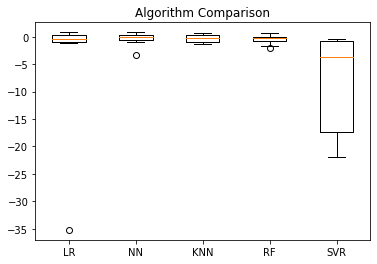

In [116]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

import warnings
from sklearn.exceptions import ConvergenceWarning


# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
        
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

# Testing GridSearching

In [117]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [118]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [119]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_results(y_true, y_pred)

explained_variance:  0.7638
mean_squared_log_error:  0.1916
r2:  0.7601
MAE:  73.3067
MSE:  10898.3484
RMSE:  104.3952


# Testing

In [128]:
data_consumption_v2 = data_consumption.copy()

data_consumption_v2.loc[:,'Last_Week'] = data_consumption_v2.loc[:,'idle_time'].shift(periods=7)
data_consumption_v2.loc[:,'Last_Week_Diff'] = data_consumption_v2.loc[:,'Last_Week'].diff()

data_consumption_v2.loc[:,'Last_Year'] = data_consumption_v2.loc[:,'idle_time'].shift(periods=365)
data_consumption_v2.loc[:,'Last_Year_Diff'] = data_consumption_v2.loc[:,'Last_Year'].diff()
data_consumption_v2 = data_consumption_v2.fillna(0)

In [129]:
data_consumption_v2.tail()

,idle_time,bike_count,Yesterday,Yesterday_Diff,temp,rain,snow,Last_Week,Last_Week_Diff,Last_Year,Last_Year_Diff
date,,,,,,,,,,,
2021-09-21,79.357143,84.0,90.793103,-0.312957,16.03,0.0,0.0,69.884211,-34.541321,110.931677,25.651374
2021-09-22,106.333333,63.0,79.357143,-11.435961,17.38,0.0,0.0,172.236842,102.352632,98.740260,-12.191417
2021-09-23,76.300000,90.0,106.333333,26.976190,21.96,0.0,0.0,92.901099,-79.335743,111.183908,12.443648
2021-09-24,96.343511,131.0,76.300000,-30.033333,17.75,0.0,0.0,66.949367,-25.951732,117.342391,6.158483
2021-09-25,62.956989,93.0,96.343511,20.043511,21.81,0.0,0.0,89.529412,22.580045,151.321839,33.979448


In [130]:
X_train_2o = data_consumption_v2[:'2020'].drop(['idle_time'], axis = 1)
y_train_2o = data_consumption_v2.loc[:'2020', 'idle_time']
X_test = data_consumption_v2['2021'].drop(['idle_time'], axis = 1)
y_test = data_consumption_v2.loc['2021', 'idle_time']

/var/folders/5t/28jzvs016nq5vxslb670gs040000gn/T/ipykernel_1268/1832955299.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_test = data_consumption_v2['2021'].drop(['idle_time'], axis = 1)


In [131]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o, y_train_2o)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.7567
mean_squared_log_error:  0.1808
r2:  0.752
MAE:  73.908
MSE:  11267.0447
RMSE:  106.1463


# variable importance plot

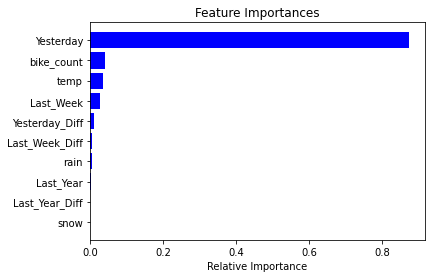

In [134]:
imp = best_model.feature_importances_
features = X_train_2o.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [135]:
data_consumption_v2.to_csv('../data/ts_data_hex_881f1a8cb7fffff_3y.csv', index=False)

In [140]:
def plottmp(x):
    fig, ax1 = plt.subplots(figsize = (20,10))
    
    ax1.plot(x['idle_time'], linewidth=2,color='red', label='Idle Time Mean')
    ax1.set_xlabel('day')
    ax1.set_ylabel('timestood (min)')
    ax1.tick_params(axis ='y', labelcolor = 'red') 
    
    ax2 = ax1.twinx()
    ax2.plot(x['bike_count'], linewidth=2, label='bike_count')
    ax2.set_ylabel('bike_count')
    ax2.tick_params(axis ='y', labelcolor = 'blue')
    
    plt.show()

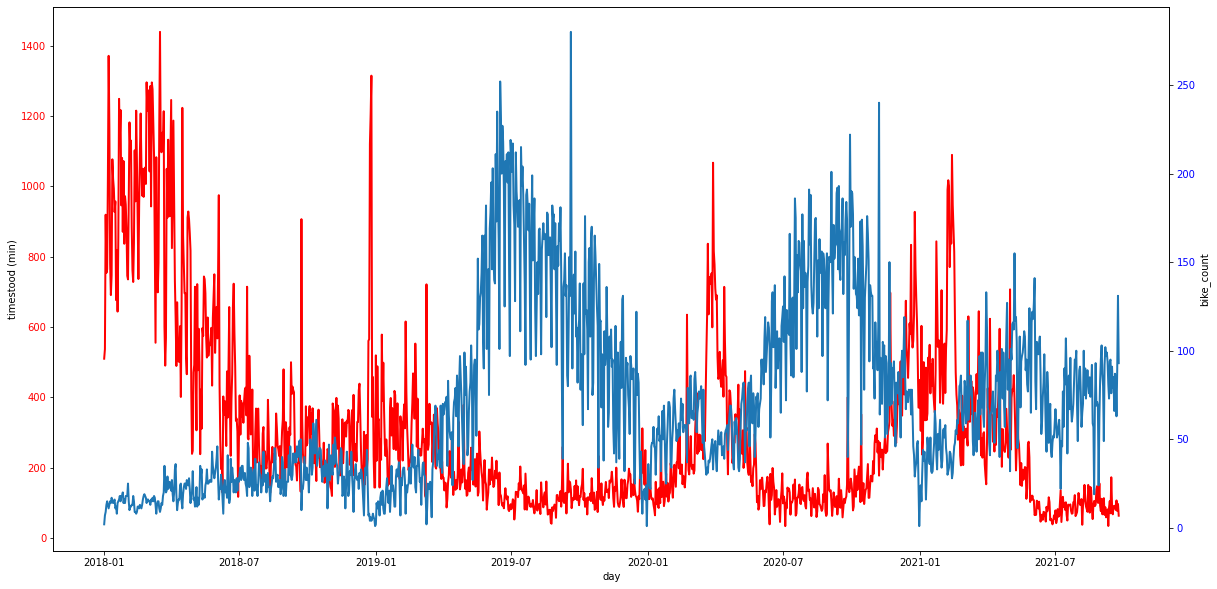

In [141]:
plottmp(data_consumption_v2)